In [30]:
!pip install deap pandas numpy

In [31]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import json

In [32]:
flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

In [33]:
# === Настройки ===
NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
CYCLE_FIXED = 120
GENE_SIZE = 3  # green_main, green_sec, offset
CHROMOSOME_SIZE = NUM_INTERSECTIONS * GENE_SIZE

In [34]:
# === Целевая функция с весом задержки от bus_share ===
def fitness(individual):
    total_delay = 0

    for i in range(NUM_INTERSECTIONS):
        idx = i * GENE_SIZE
        green_main = individual[idx]
        green_sec = individual[idx + 1]
        offset = individual[idx + 2]

        inter_id = i + 1
        int_flows = flows[flows['intersection_id'] == inter_id]

        for _, row in int_flows.iterrows():
            is_main = row['approach'] in ['N', 'S']
            flow = row['intensity_veh_per_hr']
            bus_share = row['bus_share']
            green = green_main if is_main else green_sec

            # Безусловный приоритет автобусам (по всем направлениям)
            bus_bonus = constraints["min_extra_green_sec"]
            effective_green = min(CYCLE_FIXED, green + bus_bonus)

            # Весовая задержка: больший вес — если много автобусов
            weight = 1 + 2 * bus_share
            delay = (CYCLE_FIXED - effective_green) * flow * weight

            total_delay += delay

    # Пенальти за рассинхрон offset (зелёная волна)
    offset_penalty = 0
    for i in range(1, NUM_INTERSECTIONS):
        prev = individual[(i - 1) * GENE_SIZE + 2]
        curr = individual[i * GENE_SIZE + 2]
        expected = prev + TRAVEL_TIME
        offset_penalty += abs(curr - expected)

    return total_delay + 1000 * offset_penalty,


In [35]:
# === Проверка ограничений ===
def check_constraints(ind):
    for i in range(NUM_INTERSECTIONS):
        idx = i * GENE_SIZE
        g1, g2, o = ind[idx:idx+3]
        lost = 2 * constraints["lost_time_sec_per_phase"]

        if g1 < constraints["pedestrian_green_sec"] or g2 < constraints["pedestrian_green_sec"]:
            return False
        if g1 + g2 + lost > CYCLE_FIXED:
            return False
        if not (0 <= o <= CYCLE_FIXED):
            return False
    return True


In [36]:
# === Инициализация GA ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [37]:
def random_signal_fixed_cycle():
    g1 = random.randint(constraints['min_green_sec'], 60)
    g2 = random.randint(constraints['min_green_sec'], 60)
    lost = 2 * constraints["lost_time_sec_per_phase"]
    while g1 + g2 + lost > CYCLE_FIXED:
        g1 -= 1
    offset = random.randint(0, CYCLE_FIXED)
    return [g1, g2, offset]
toolbox.register("individual", tools.initIterate, creator.Individual, 
                 lambda: sum([random_signal_fixed_cycle() for _ in range(NUM_INTERSECTIONS)], []))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.4)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [38]:
def feasible(ind):
    return check_constraints(ind)

toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 1e6))

In [39]:
import json

def run_ga():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=50, 
                        stats=stats, halloffame=hof, verbose=True)

    best = hof[0]

    # 💾 Сохраняем best в файл
    with open("best_solution.json", "w") as f:
        json.dump(best, f)

    print("\n=== ЛУЧШЕЕ РЕШЕНИЕ (ЦИКЛ 120 СЕК) ===")
    for i in range(NUM_INTERSECTIONS):
        idx = i * GENE_SIZE
        g1, g2, o = best[idx:idx+3]
        print(f"Перекрёсток {i+1}: цикл=120, главная={g1:.0f}, второстепенная={g2:.0f}, offset={o:.0f}")
    print("Оценка:", fitness(best)[0])


In [40]:
if __name__ == "__main__":
    run_ga()

gen	nevals	avg   	min   
0  	100   	838322	647988
1  	74    	819600	647988
2  	86    	786363	635957
3  	75    	764386	635957
4  	87    	720421	625635
5  	75    	698933	593691
6  	73    	669406	591146
7  	76    	659485	577080
8  	69    	633160	571861
9  	77    	634939	560002
10 	78    	649932	550041
11 	75    	652750	550041
12 	83    	637081	548774
13 	76    	645252	549737
14 	66    	619196	539844
15 	68    	618487	539844
16 	72    	627785	535731
17 	72    	648506	536421
18 	67    	629140	535400
19 	84    	636767	534499
20 	74    	624319	529725
21 	74    	631291	529725
22 	63    	596573	526265
23 	72    	644984	523851
24 	80    	650095	519291
25 	81    	637819	512827
26 	74    	663536	511642
27 	71    	618571	511458
28 	82    	615638	510010
29 	80    	587452	510276
30 	79    	580994	510276
31 	78    	588319	506947
32 	76    	567492	504301
33 	74    	576046	502727
34 	74    	602548	502205
35 	80    	578721	502205
36 	86    	557097	502144
37 	78    	550591	499986
38 	77    	529412	499772


In [41]:
# === Входные данные ===
flows = pd.read_csv("flows_peak.csv")
signals = pd.read_csv("signals_current.csv")

with open("constraints.json") as f:
    constraints = json.load(f)

total_delay = 0


In [42]:
for _, row in flows.iterrows():
    inter_id = row['intersection_id']
    approach = row['approach']
    flow = row['intensity_veh_per_hr']
    bus_share = row['bus_share']

    sig = signals[signals['intersection_id'] == inter_id].iloc[0]

    cycle = sig['cycle_sec']
    green_main = sig['green_main_sec']
    green_sec = sig['green_secondary_sec']

    # Направление
    is_main = approach in ['N', 'S']
    green = green_main if is_main else green_sec

    # Приоритет автобусов
    bus_bonus = constraints["min_extra_green_sec"]
    effective_green = min(cycle, green + bus_bonus)

    delay = (cycle - effective_green) * flow
    total_delay += delay

print(f"💡 Общая задержка ДО оптимизации: {total_delay:.2f}")


💡 Общая задержка ДО оптимизации: 690500.00


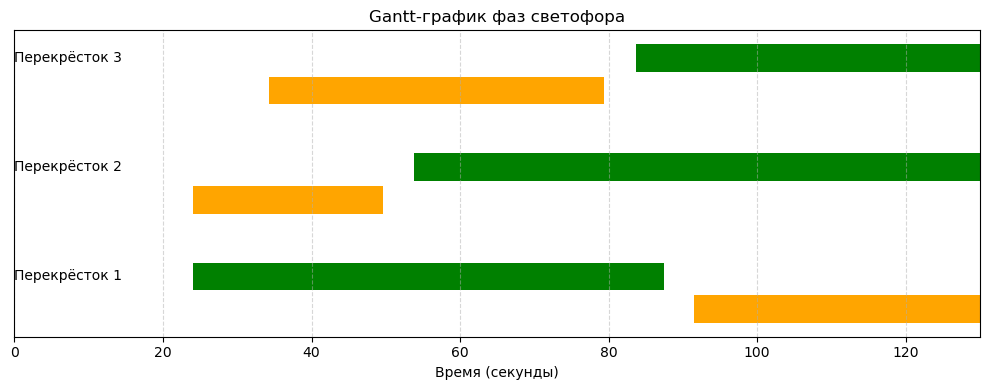

💡 Общая задержка по автобусным потокам: 23403.28 машино-секунд


In [43]:
import json
import matplotlib.pyplot as plt

# Загрузка лучшего решения из файла
with open("best_solution.json", "r") as f:
    best = json.load(f)

signal_plan = {}
for i in range(NUM_INTERSECTIONS):
    idx = i * 3
    inter_id = i + 1
    signal_plan[inter_id] = {
        "cycle": 120,
        "main": best[idx],
        "sec": best[idx + 1],
        "offset": best[idx + 2]
    }

# flows_peak.csv — данные о потоках
flows = pd.read_csv("flows_peak.csv")

# Вычисление задержки только по автобусным потокам
bus_delay_total = 0
for inter_id, plan in signal_plan.items():
    flows_inter = flows[flows["intersection_id"] == inter_id]
    for _, row in flows_inter.iterrows():
        is_main = row["approach"] in ["N", "S"]
        flow = row["intensity_veh_per_hr"]
        bus_share = row["bus_share"]
        flow_bus = flow * bus_share
        green = plan["main"] if is_main else plan["sec"]
        bonus = 5  # min_extra_green_sec
        eff_green = min(plan["cycle"], green + bonus)
        delay = (plan["cycle"] - eff_green) * flow_bus
        bus_delay_total += delay

# Построение Gantt-графика
fig, ax = plt.subplots(figsize=(10, 4))
colors = {"main": "green", "sec": "orange"}

for i, (inter_id, plan) in enumerate(signal_plan.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6
    ax.broken_barh([(plan["offset"], plan["main"])], (y_main, 0.5), facecolors=colors["main"])
    offset_sec = (plan["offset"] + plan["main"] + 4) % plan["cycle"]
    ax.broken_barh([(offset_sec, plan["sec"])], (y_sec, 0.5), facecolors=colors["sec"])
    ax.text(0, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

ax.set_yticks([])
ax.set_xlim(0, 130)
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"💡 Общая задержка по автобусным потокам: {bus_delay_total:.2f} машино-секунд")
